---
layout: notes
chapter: 2
chapter-title: End-to-End Machine Learning Project
permalink: /ml-book/chapter2/notes.html
---

## The Process
* Big Picture (Problem Statement)
* Get Data
* Exploratory Data Analysis
* Data Preparation
* Model selection and training
* Fine-tune the model
* Production
* Monitor and Maintain

## Frame the Problem

### The Task
* Build a model to predict housing prices in California given California census data. Specifically, predict the median housing price in any district, given all other metrics. 

### Additional Considerations
* Determine how exactly the result of your model is going to be used
  * In this instance it will be fed into another machine learning model downstream
  * Current process is a manual one which is costly and time consuming
  * Typical error rate of the experts is 15%
* Questions to ask yourself:
  * Is it supervised, unsupervised, or Reinforcement Learning? Supervised (because we have labels of existing median housing price
  * Is it a classification, regression or something else? It's a regression task, we're predicting a number
  * Should you use batch learning or online learning? Depends on the volume of data, but probably batch learning.

## RMSE (Root Mean Squared Error)
Measures the standard deviation of the errors the system makes in its predictions. Recall the standard deviation is:

$$ \sigma = \sqrt{\frac{\sum_{i}{(\bar{X} - X_i)^2}}{N}} $$

Analogously RMSE is:

$$ RMSE = \sqrt{\frac{\sum_{i}{(y_i - f(X_i))^2}}{N}} $$

where $f$ is our model. There is also Mean Absolute Error (MAE). RMSE is more 
sensitive to outliers than MAE because for large outliers (i.e. differences) 
RMSE will make them larger by squaring them.

## Get the Data

In [1]:
import tarfile
import tempfile
import urllib.request
import os
import pandas as pd

housing_url = (
    "https://raw.githubusercontent.com/ageron/"
    + "handson-ml/master/datasets/housing/housing.tgz"
)
FIGSIZE = (16, 12)


def read_tar(url):
    r = urllib.request.urlopen(url)
    with tempfile.TemporaryDirectory() as d:
        with tarfile.open(fileobj=r, mode="r:gz") as tf:
            tf.extractall(path=d)
            name = tf.getnames()[0]
        df = pd.read_csv(os.path.join(d, name))
    return df


df = read_tar(housing_url)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


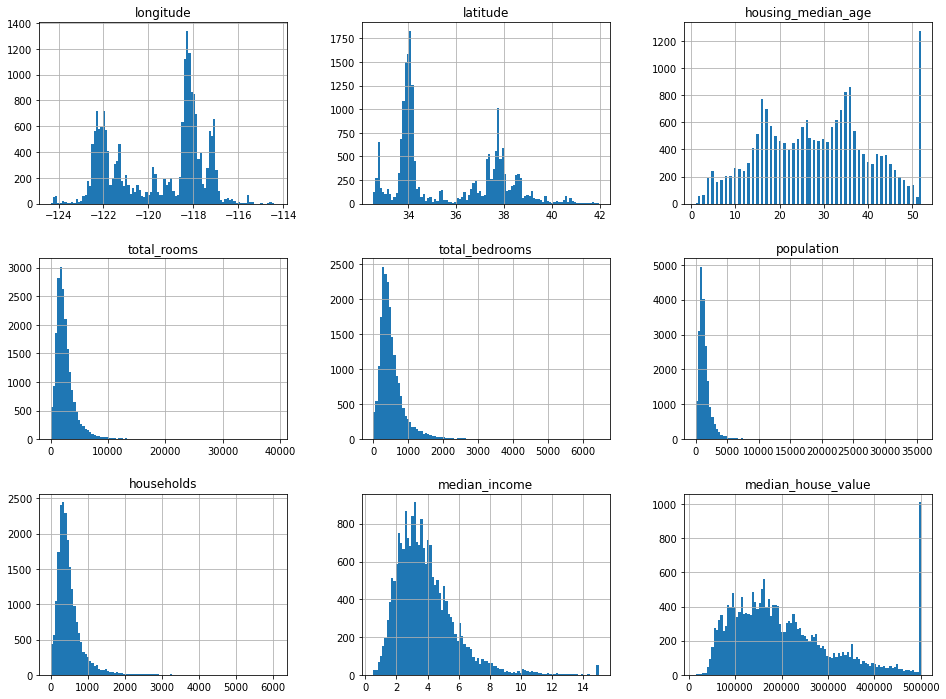

In [2]:
# Show histogram of the features
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(bins=100, figsize=(16, 12))

In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Things to note
* Several columns seem to be capped out a max value (e.g. `housing_median_age`)
* `median_income` isn't in dollars
* Many distributions are right-skewed (hump on left, called tail-heavy)

### Things mentioned by Geron
* `median_income` isn't in dollars
* `housing_median_age` and `median_housing_value` are capped
  * The latter might be problematic because it is our target variable. To remedy he suggests:
    * Collect correct labels for those
    * Remove those districts from the training/test set
* Different scales
* Tail heavy

## Create a Test Set
* Most of the time you're going to be fine with randomly sampling/splitting into train/test
* Geron suggests stratified sampling (5 splits) based on median income
* We'll try both with a 20% test size

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Let's see how similar these are:

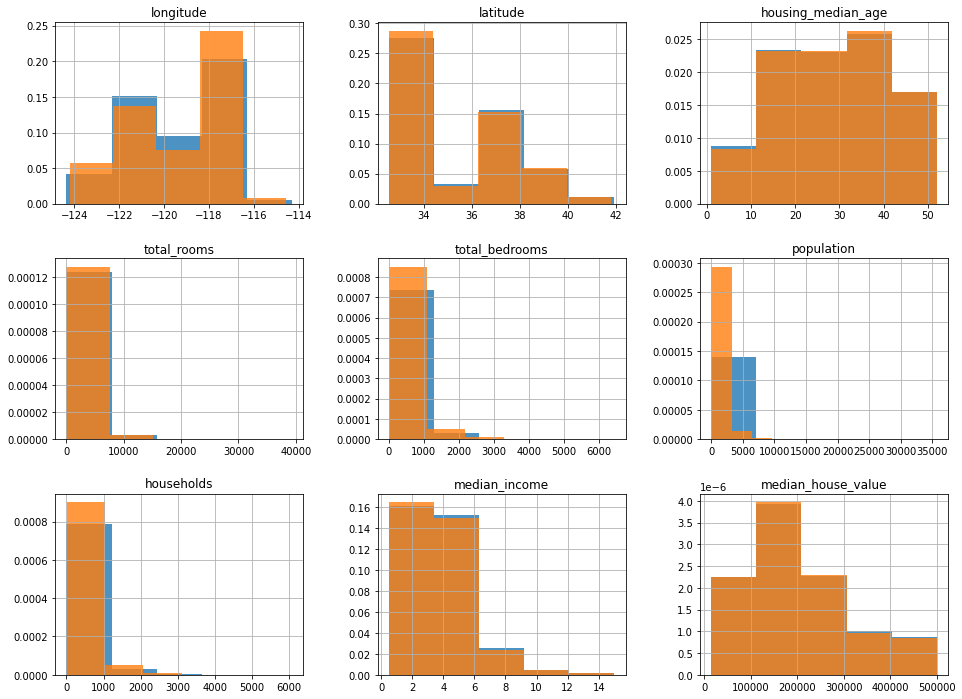

In [5]:
ax = train_set.hist(bins=5, figsize=(16, 12), density=True, alpha=0.8)
test_set.hist(bins=5, figsize=(16, 12), ax=ax, density=True, alpha=0.8)

That looks pretty good to me. But we'll also do the stratified method:

[ 0.4989  2.3523  3.1406  3.9673  5.1098 15.0011]
2    4131
1    4130
4    4128
5    4127
3    4124
dtype: int64


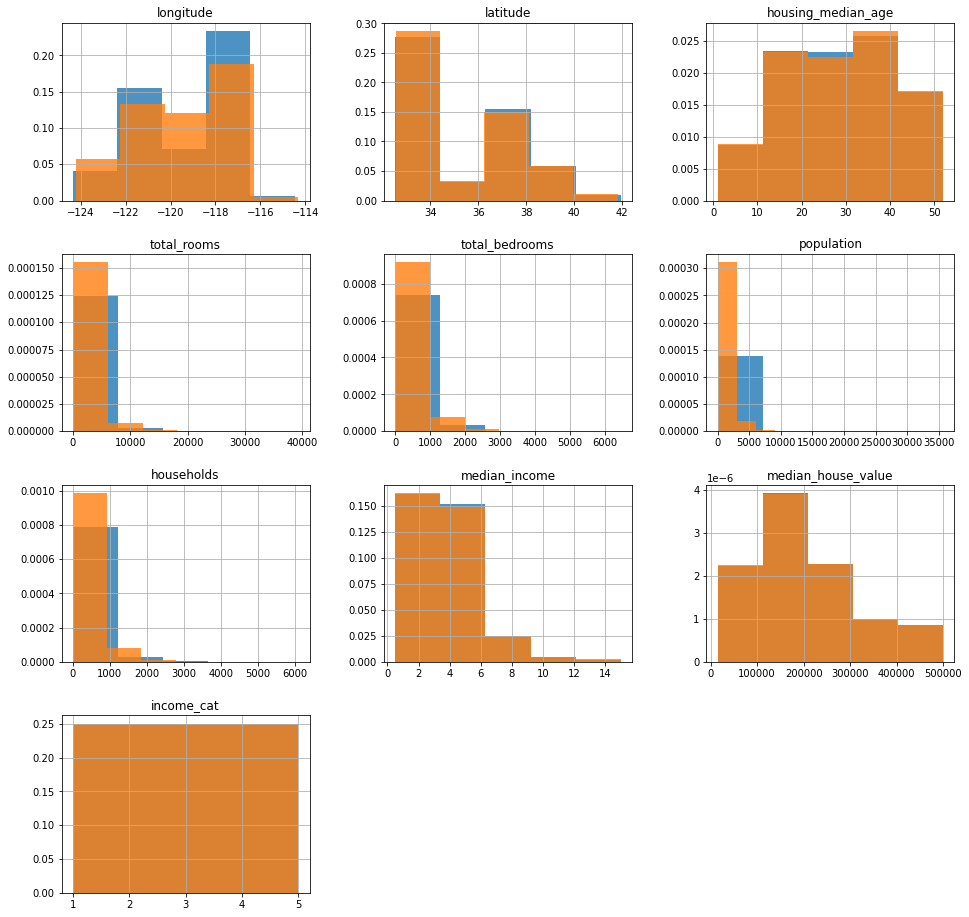

In [6]:
# Sample to same count in each bin (5 bins)
# We can come back and try this at the end to see how if the performance improves?
import numpy as np
import pandas as pd

strat_values = df["median_income"]
bins = 5
x = np.linspace(0, len(strat_values), bins + 1)
xp = np.arange(len(strat_values))
fp = np.sort(strat_values)
bin_ends = np.interp(x, xp, fp)
# Make sure we include the bin ends and end up with 5 bins in the end
bin_ends[0] -= 0.001
bin_ends[-1] += 0.001
strat = np.digitize(strat_values, bins=bin_ends, right=True)
print(bin_ends)
print(pd.value_counts(strat))
df["income_cat"] = strat
strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, random_state=42, stratify=strat
)
ax = strat_train_set.hist(bins=5, figsize=(16, 16), density=True, alpha=0.8)
strat_test_set.hist(
    bins=5, figsize=(16, 16), ax=ax.flatten()[:-2], density=True, alpha=0.8
)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: median_income, dtype: float64


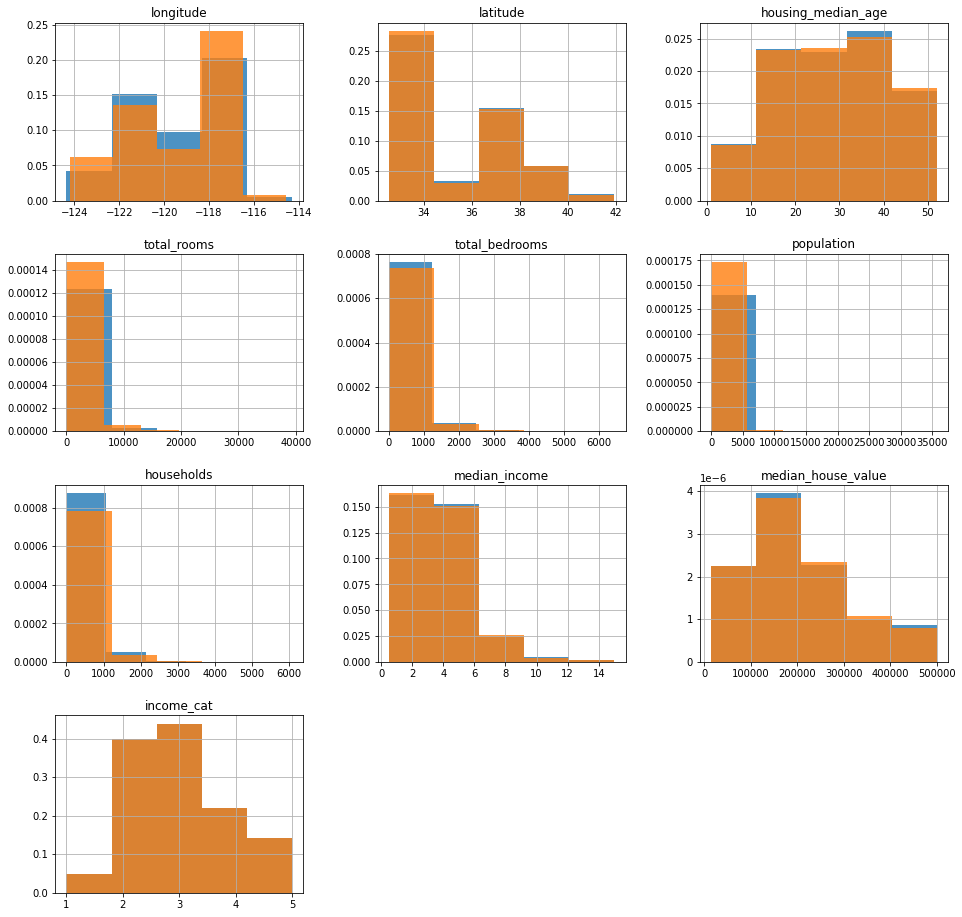

In [7]:
strat_values = df["median_income"]
bins = 5
strat = np.ceil(strat_values / 1.5)
strat = strat.where(strat < 5, 5.0)
df["income_cat"] = strat
print(pd.value_counts(strat) / len(strat))
strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, random_state=42, stratify=strat
)
ax = strat_train_set.hist(bins=5, figsize=(16, 16), density=True, alpha=0.8)
strat_test_set.hist(
    bins=5, figsize=(16, 16), ax=ax.flatten()[:-2], density=True, alpha=0.8
)

I feel like this doesn't matter at all...

In [8]:
# Drop the income_cat column
cols = [i for i in df.columns if i != "income_cat"]
df = df.loc[:, cols]
strat_train_set = strat_train_set.loc[:, cols]
strat_test_set = strat_test_set.loc[:, cols]
# Only work with train set from here on out
df = strat_train_set.copy()

## Visualize the Data to Gain Insights
* Visualize geographically based on target variable
* Correlations
* Combining features

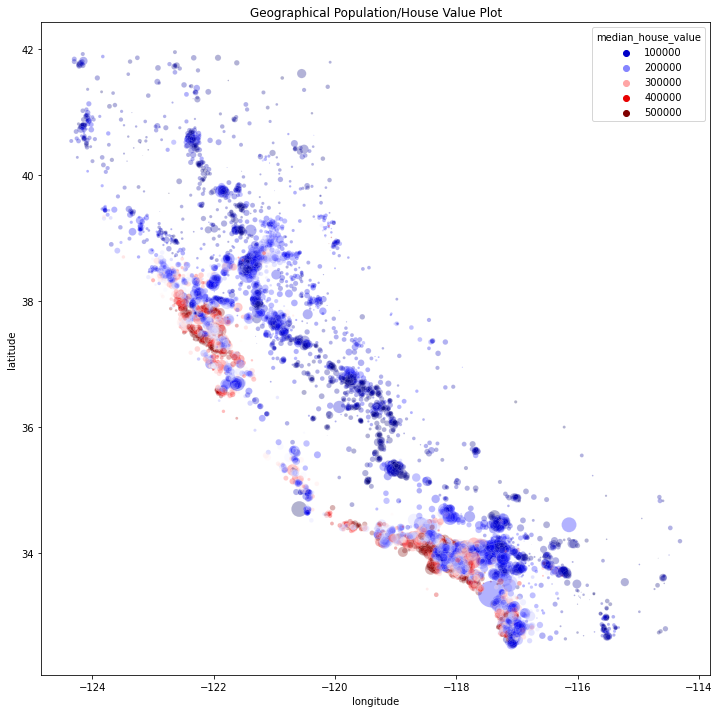

In [9]:
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.scatterplot(
    x="longitude",
    y="latitude",
    data=df,
    s=df["population"] / 50,
    hue=df["median_house_value"],
    alpha=0.3,
    palette="seismic",
)
plt.title("Geographical Population/House Value Plot")

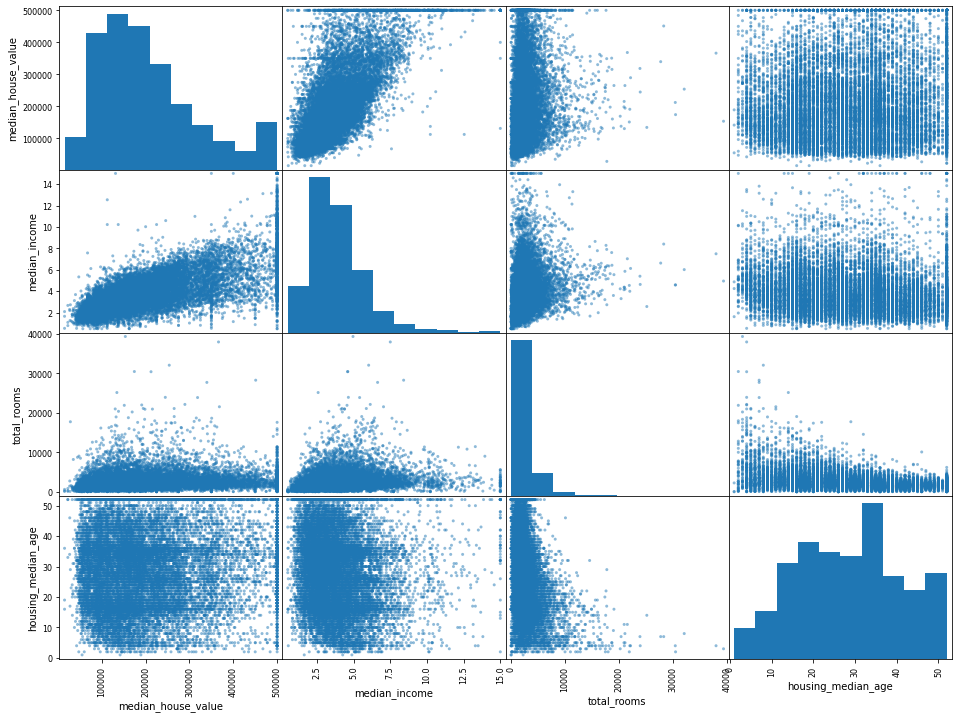

In [10]:
# Correlations
corr = df.corr()
corr["median_house_value"].sort_values(ascending=False)
# Scatter
from pandas.plotting import scatter_matrix

scatter_matrix(
    df[["median_house_value", "median_income", "total_rooms", "housing_median_age"]],
    figsize=(16, 12),
)

In [11]:
# Combining features
df["population_per_household"] = df["population"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df.corr()["median_house_value"].sort_values(ascending=False)
# Not sure why rooms_per_household was 0.05 less than Geron...

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms
* Data Cleaning
  * Handle missing data in `total_bedrooms`
    * Option 1: Remove column entirely (kind of a lousy option considering only a few districts are missing and we just created a combo feature based on it)
    * Option 2: Remove those districts (have to remove from test set as well)...
    * Option 3: Fill value (mean, median, etc.)
  * We'll just go with option 3, using the median as Geron does
  * He makes a good point, that we should use the imputer on _all_ numerical variables because for future data there might be missing data in other columns

In [12]:
target = "median_house_value"
x = df[[col for col in df.columns if col != target]].copy()
y = df[[target]].copy()

In [13]:
# Impute the median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(x.drop(columns="ocean_proximity"))
print(list(imputer.statistics_.round(2)))
x_num = imputer.transform(x.drop(columns="ocean_proximity"))
print(x_num)

[-118.51, 34.26, 29.0, 2119.5, 433.0, 1164.0, 408.0, 3.54, 2.82, 0.2, 5.23]
[[-121.89         37.29         38.         ...    2.09439528
     0.22385204    4.62536873]
 [-121.93         37.05         14.         ...    2.7079646
     0.15905744    6.00884956]
 [-117.2          32.77         31.         ...    2.02597403
     0.24129098    4.22510823]
 ...
 [-116.4          34.09          9.         ...    2.74248366
     0.17960865    6.34640523]
 [-118.01         33.82         31.         ...    3.80898876
     0.19387755    5.50561798]
 [-122.45         37.77         52.         ...    1.98591549
     0.22035541    4.84350548]]


## Scikit-Learn Design
* Consistency
  * All objects share a consistent and simple interface:
    * Esimators: 
      * Any object can estimate some parameters based on a dataset
      * Estimation is performed by calling `fit`
      * Hyperparameters are set at instantiation
    * Transformers:
      * Estimators which can transform a dataset
      * Transformation is performed by calling `transform` with the dataset as the arg
      * It returns the transformed dataset
      * Some transformers have an optimized `fit_transform` method which runs both steps
    * Predictors:
      * Estimators which can make predictions on a dataset
      * Prediction is performed by calling `predict` with the new dataset as the arg
      * They also have a score used to evaluate the quality of predictions
  * Inspection:
    * Hyperparameters of estimators are available in public instance variables
    * Learn parameters of estimators are available, and their variables end with an underscore
  * Nonproliferation of classes:
    * Datasets are numpy or scipy arrays or sparse matrices
    * Hyperparameters are python datatypes
  * Composition:
    * Existing building blocks are resused as much as possible
  * Sensible defaults:
    * Estimators have sensible defaults for their hyperparameters
  

## Handling Text and Categorical Attributes
* Machine learning algorithms need to work with numbers so we encode textual data as numerical input
* A label encoder will map labels into integers
  * But, most ML algorithms will assume that numbers closer together are more similar
* Therefore we can use a one hot encoding to create binary labels for each category
* `LabelBinarizer` is the combination of these steps

In [14]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
x_cat = encoder.fit_transform(x[["ocean_proximity"]])
x_cat
# OneHotEncoder functionality has improved so we use that later on in favor of LabelBinarizer

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

I'm going to avoid the custom transformer for now.

## Feature Scaling
* **With few exceptions, ML algorithms do not perform well when the input numerical attributes have very different scales**
* Min-max scaling or Normalization: values are rescaled to 0 - 1
  * Use `MinMaxScaler`
* Standardization: Zero mean and unit variance
  * Much less affected by outliers
  * Use `StandardScaler`
* Only feature scale on training set

In [15]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

cat_cols = ["ocean_proximity"]
num_cols = [col for col in x.columns if col not in cat_cols]

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ]
)

pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(), cat_cols),
    ]
)
x_final = pipeline.fit_transform(x)
print(x_final)
print(x_final.shape)
# In the copy of the book I have the shape is (16513, 17),
# but in the updated version
# online: https://github.com/ageron/handson-ml/blob
# /master/02_end_to_end_machine_learning_project.ipynb
# it is (16512, 16)

[[-1.15604281  0.77194962  0.74333089 ...  0.          0.
   0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...  0.          0.
   0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...  0.          0.
   1.        ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.          0.
   0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.          0.
   0.        ]
 [-1.43579109  0.99645926  1.85670895 ...  0.          1.
   0.        ]]
(16512, 16)


## A Note
It's good to reference [the notebooks here](https://github.com/ageron/handson-ml) because Geron updated them with new ideas and changes that have been made in new scikit-learn versions! Example of this above is `ColumnTransformer` and the change in behavior of `OneHotEncoder`.

## Select and Train a Model

   >At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for Machine Learning algorithms automatically. You are now ready to select and train a Machine Learning model.
   
That was straight from Geron, the excitement is palpable :)

## Training and Evaluating on the Training Set

In [16]:
from sklearn.linear_model import LinearRegression

y_final = y.copy().values

lin_reg = LinearRegression()
lin_reg.fit(x_final, y_final)

# Some predictions
x_5 = x_final[:5, :]
y_5 = y_final[:5]
print(list(lin_reg.predict(x_5)[:, 0].round(2)))
print(list(y_5[:, 0]))

[209375.74, 315154.78, 210238.28, 55902.62, 183416.69]
[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [17]:
from sklearn.metrics import mean_squared_error

lin_preds = lin_reg.predict(x_final)
lin_mse = mean_squared_error(y_final, lin_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse  # Better than Geron :)

68161.22644433199

Text(0.5, 1.0, 'Median House Price: Predictions vs. Labels')

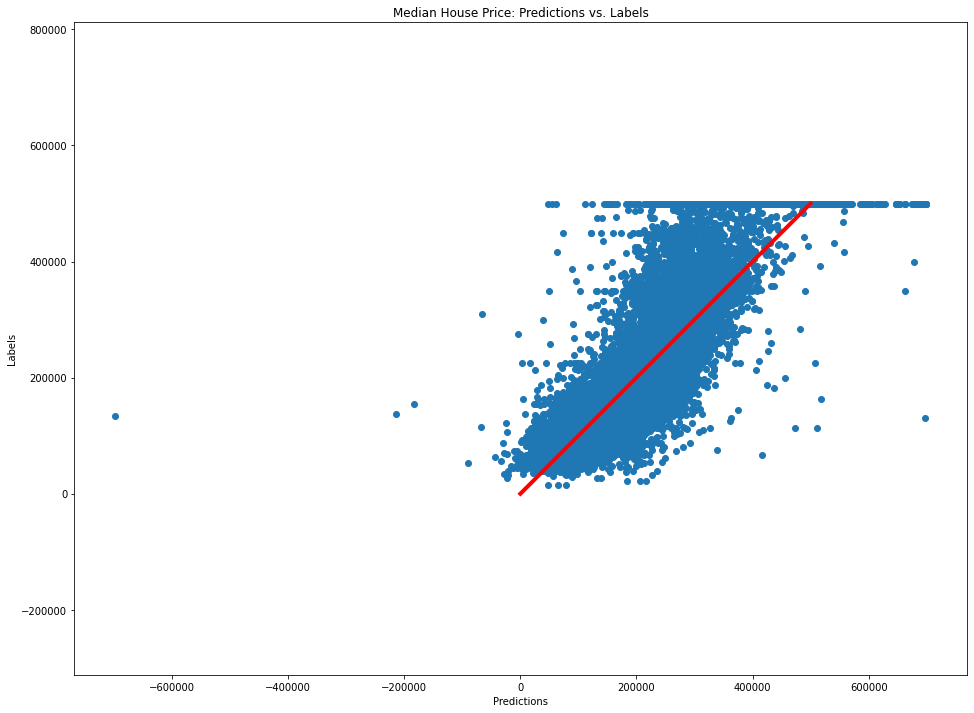

In [18]:
# Let's plot this
plt.figure(figsize=FIGSIZE)
plt.scatter(lin_preds[:, 0], y_final[:, 0])
plt.plot(np.arange(max(y_final[:, 0])), np.arange(max(y_final[:, 0])), c="r", lw=4)
plt.axis("equal")
plt.xlabel("Predictions")
plt.ylabel("Labels")
plt.title("Median House Price: Predictions vs. Labels")

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(x_final, y_final)
tree_preds = tree_reg.predict(x_final)
tree_mse = mean_squared_error(y_final, tree_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Underfitting and Overfitting
* Clearly the LinearRegression model is underfitting
* The DecisionTreeRegressor model is overfitting

## K-fold Cross Validation
* Split the training data k folds
* Iterate it k times using k-1 folds for training and one for the test set
* Evaluate on the test_set k times

In [20]:
from sklearn.model_selection import cross_val_score


def cross_val_model(m, x_m, y_m, cv=10):
    scores = cross_val_score(m, x_m, y_m, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    print(rmse_scores, np.mean(rmse_scores), np.std(rmse_scores))


cross_val_model(tree_reg, x_final, y_final)

[70968.72056379 67216.68718226 70857.65880397 69194.86108641
 69756.29757786 74386.85421573 69949.56290335 69745.34537599
 75022.85006194 70755.92128417] 70785.47590554852 2215.1990085744


In [21]:
cross_val_model(lin_reg, x_final, y_final)

[66060.65470195 66764.30726969 67721.72734022 74719.28193624
 68058.11572078 70909.35812986 64171.66459204 68075.65317717
 71024.84033989 67300.24394751] 68480.58471553595 2845.5843092650853


In [22]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(x_final, y_final[:, 0])
forest_preds = forest_reg.predict(x_final)
forest_mse = mean_squared_error(forest_preds, y_final)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)
cross_val_model(forest_reg, x_final, y_final[:, 0])

18681.372911866638
[49635.15372436 47754.83871792 49368.25902706 51887.71850715
 49747.11331684 53513.21033152 49044.38099493 47851.45135021
 52535.51927089 50181.50476447] 50151.91500053619 1824.9254115323


Text(0.5, 1.0, 'Median House Price (forest_reg): Predictions vs. Labels')

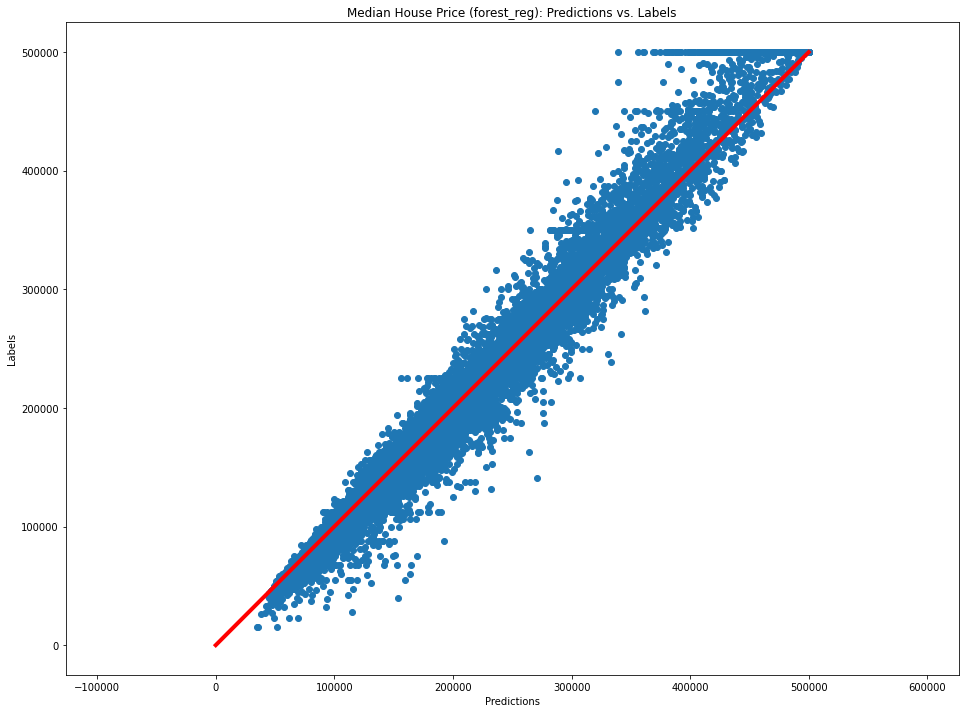

In [23]:
plt.figure(figsize=FIGSIZE)
plt.scatter(forest_preds, y_final[:, 0])
plt.plot(np.arange(max(y_final[:, 0])), np.arange(max(y_final[:, 0])), c="r", lw=4)
plt.axis("equal")
plt.xlabel("Predictions")
plt.ylabel("Labels")
plt.title("Median House Price (forest_reg): Predictions vs. Labels")

## Fine-Tune Your Model
* Hyper parameter tuning via `GridSearchCV`

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
grid_search.fit(x_final, y_final[:, 0])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
print(grid_search.best_params_)
# Since these were the max we probably want to run it with higher values...
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(max_features=6, n_estimators=30)
64241.643733474426 {'max_features': 2, 'n_estimators': 3}
55493.95031384657 {'max_features': 2, 'n_estimators': 10}
52611.35103475831 {'max_features': 2, 'n_estimators': 30}
59612.070906720124 {'max_features': 4, 'n_estimators': 3}
53217.142164320154 {'max_features': 4, 'n_estimators': 10}
50774.31443657333 {'max_features': 4, 'n_estimators': 30}
58496.50322845977 {'max_features': 6, 'n_estimators': 3}
51673.17455491991 {'max_features': 6, 'n_estimators': 10}
49905.43427800321 {'max_features': 6, 'n_estimators': 30}
58415.20435335512 {'max_features': 8, 'n_estimators': 3}
51769.879435332965 {'max_features': 8, 'n_estimators': 10}
50108.24515443716 {'max_features': 8, 'n_estimators': 30}
63641.17748807948 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54078.8506451545 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60653.00976167665 {'bootstrap': False, 'max_features': 

In [26]:
# 49744.32698468949 is better than the 50063.56307010515 that we got earlier
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.074970,0.003440,0.004058,0.000327,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.725274e+09,-4.519071e+09,...,-4.126989e+09,2.782979e+08,18,-1.174094e+09,-1.137123e+09,-1.135578e+09,-1.161493e+09,-1.173606e+09,-1.156379e+09,1.697186e+07
1,0.253067,0.006757,0.013049,0.000900,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.902669e+09,-3.157306e+09,...,-3.079579e+09,1.487250e+08,11,-5.985522e+08,-5.762183e+08,-5.598208e+08,-5.842322e+08,-5.538692e+08,-5.745385e+08,1.623130e+07
2,0.766241,0.061197,0.041019,0.012172,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.522423e+09,-2.879564e+09,...,-2.767954e+09,1.561066e+08,7,-4.315321e+08,-4.233639e+08,-4.226476e+08,-4.443902e+08,-4.293808e+08,-4.302629e+08,7.842951e+06
3,0.117724,0.002772,0.004679,0.000370,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.327938e+09,-3.817583e+09,...,-3.553599e+09,2.235334e+08,15,-9.922077e+08,-9.869361e+08,-9.914129e+08,-9.018709e+08,-9.423203e+08,-9.629496e+08,3.577073e+07
4,0.396204,0.010106,0.012332,0.000672,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.740772e+09,-2.832407e+09,...,-2.832064e+09,1.248181e+08,9,-5.299414e+08,-5.012337e+08,-5.068510e+08,-5.150394e+08,-5.214479e+08,-5.149027e+08,1.020482e+07
5,1.183900,0.032037,0.034720,0.003109,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.458769e+09,-2.659611e+09,...,-2.578031e+09,1.205170e+08,3,-3.960356e+08,-3.967138e+08,-3.976908e+08,-3.966141e+08,-3.885729e+08,-3.951254e+08,3.319175e+06
6,0.163407,0.006830,0.004493,0.000744,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.348268e+09,-3.590983e+09,...,-3.421841e+09,1.263433e+08,14,-9.210685e+08,-9.293810e+08,-9.024612e+08,-9.630794e+08,-8.755641e+08,-9.183108e+08,2.902711e+07
7,0.540489,0.024100,0.012174,0.000949,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.539299e+09,-2.724873e+09,...,-2.670117e+09,1.431570e+08,4,-5.289777e+08,-4.838298e+08,-4.794369e+08,-4.998217e+08,-5.077449e+08,-4.999622e+08,1.779906e+07
8,1.557723,0.008208,0.032147,0.001470,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.311978e+09,-2.530306e+09,...,-2.490552e+09,1.364425e+08,1,-3.738081e+08,-3.723503e+08,-3.776112e+08,-3.963427e+08,-3.891545e+08,-3.818534e+08,9.341090e+06
9,0.199586,0.008718,0.003961,0.000096,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.293286e+09,-3.533084e+09,...,-3.412336e+09,1.883880e+08,13,-9.155409e+08,-8.965800e+08,-8.831597e+08,-8.852660e+08,-9.669854e+08,-9.095064e+08,3.094863e+07


## Other Methods to Fine Tune
* Randomized Search:
  * Iteration dependent so it can explore more options for hyperparameters
  * More control of computing budget
* Ensemble Methods:
  * Combining the models which perform the best

## Feature Importance

In [27]:
attributes = list(df.columns) + list(encoder.classes_)
attributes.remove("median_house_value")
attributes.remove("ocean_proximity")
importances = grid_search.best_estimator_.feature_importances_
sorted(zip(importances, attributes), reverse=True)

[(0.3317845401920315, 'median_income'),
 (0.14391320344674868, 'INLAND'),
 (0.10526089823364354, 'population_per_household'),
 (0.08263855622539133, 'bedrooms_per_room'),
 (0.08109436950269967, 'longitude'),
 (0.06119936528237925, 'latitude'),
 (0.05437513667126127, 'rooms_per_household'),
 (0.04269180191935387, 'housing_median_age'),
 (0.018543650605563098, 'population'),
 (0.017855965561009164, 'total_rooms'),
 (0.01747459825864214, 'total_bedrooms'),
 (0.016371631697584668, 'households'),
 (0.015137593949840484, '<1H OCEAN'),
 (0.006837130390816489, 'NEAR OCEAN'),
 (0.004801246718794319, 'NEAR BAY'),
 (2.0311344240502856e-05, 'ISLAND')]

## Evaluate Your Model on the Test Set

In [28]:
final_model = grid_search.best_estimator_
print(final_model)

X_test = strat_test_set.drop(columns="median_house_value")
# Little bit of an oversight here
X_test["population_per_household"] = X_test["population"] / X_test["households"]
X_test["bedrooms_per_room"] = X_test["total_bedrooms"] / X_test["total_rooms"]
X_test["rooms_per_household"] = X_test["total_rooms"] / X_test["households"]
y_test = strat_test_set["median_house_value"].copy().values

X_test_prep = pipeline.transform(X_test)

final_preds = final_model.predict(X_test_prep)
final_mse = mean_squared_error(y_test, final_preds)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

RandomForestRegressor(max_features=6, n_estimators=30)
48308.099325390474


## Launch, Monitor, and Maintain Your System
* Plug into production data
* Write tests
* Write monitoring code to check the live performance at regular intervals and trigger alerts when it drops
  * Models tend to "rot" over time
* Evaluating performance requires sampling the system's predictions and evaluating them
* In this case we need to have the human evaluation plugged into the system
* Monitor system input data
* Automate the training process and train on fresh data
* For online learning save snapshots at regular intervals